In [1]:

# google drive. so we have to monunt
from google.colab import drive # /content/drive/MyDrive/project/MachineLearning/dataset/mnist.pkl
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import six.moves.cPickle as pickle
import gzip
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
import seaborn as sns

In [3]:
def load_data(dataset): # data load : HDLMS source code utilize
    data_dir, data_file = os.path.split(dataset)
    if data_dir == "" and not os.path.isfile(dataset):
        # Check if dataset is in the data directory.
        new_path = os.path.join(
            os.path.split('/content/drive/MyDrive/project/MachineLearning/dataset/')[0],
            dataset
        )
        if os.path.isfile(new_path) or data_file == 'mnist.pkl.gz':
            dataset = new_path

    if (not os.path.isfile(dataset)) and data_file == 'mnist.pkl.gz':
        from six.moves import urllib
        origin = (
            'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
        )
        print('Downloading data from %s' % origin)
        urllib.request.urlretrieve(origin, dataset)

    print('... loading data')

    # Load the dataset
    with gzip.open(dataset, 'rb') as f:
        try:
            train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
        except:
            train_set, valid_set, test_set = pickle.load(f)
    # train_set, valid_set, test_set format: tuple(input, target)
    # input is a numpy.ndarray of 2 dimensions (a matrix)
    # where each row corresponds to an example. target is a
    # numpy.ndarray of 1 dimension (vector) that has the same length as
    # the number of rows in the input. It should give the target
    # to the example with the same index in the input.

    return train_set, valid_set, test_set

In [4]:
if __name__ == '__main__':
    train_set, val_set, test_set = load_data('mnist.pkl.gz')

    train_x, train_y = train_set
    val_x, val_y = val_set
    test_x, test_y = test_set
    
    print(train_x.shape)
    print(train_y.shape)

... loading data
(50000, 784)
(50000,)


In [5]:
print(val_x.shape)
print(val_y.shape)

(10000, 784)
(10000,)


In [6]:
eta=0.01
alpha=0.001
n_iter= 50 # epoch test...
batch_size= 50 # batch size

In [7]:
class MLP(object):
    def __init__(self, eta=eta, alpha=alpha, n_iter=n_iter, batch_size=batch_size):
        self.eta = eta
        self.alpha = alpha
        self.n_iter = n_iter
        self.batch_size = batch_size

    def one_hot_enc(self, y, num_labels=10):
        one_hot = np.zeros((num_labels, y.shape[0]), dtype=np.float32)
    
        for i, val in enumerate(y):
            one_hot[val,i] = 1.0
    
        return one_hot

    def init_weights(self, n_input, n_hidden_1, n_hidden_2, n_output, batch_size):
        w1 = np.random.randn(n_hidden_1, n_input+1)
        w2 = np.random.randn(n_hidden_2, n_hidden_1+1)
        w3 = np.random.randn(n_output, n_hidden_2+1)
        
        return w1, w2, w3


    def add_bias_unit(self, layer, orientation):
        if orientation == 'row':
            updated_layer = np.ones((layer.shape[0]+1, layer.shape[1]))
            updated_layer[1:, :] = layer
        elif orientation == 'col':
            updated_layer = np.ones((layer.shape[0], layer.shape[1] + 1))
            updated_layer[:, 1:] = layer
    
        return updated_layer


    def compute_forward_pass(self, input):
        a1 = self.add_bias_unit(input, orientation='col')
    
        z2 = np.matmul(self.w1, a1.transpose(1, 0))
        a2 = 1/(1 + np.exp(-z2))
        a2 = self.add_bias_unit(a2, orientation='row')
    
        z3 = np.matmul(self.w2, a2)
        a3 = 1/(1 + np.exp(-z3))
        a3 = self.add_bias_unit(a3, orientation='row')
    
        z4 = np.matmul(self.w3, a3)
        a4 = 1/(1 + np.exp(-z4))
    
        return a1, z2, a2, z3, a3, z4, a4


    def predict(self, a4):
        prediction = np.argmax(a4, axis=0)
        return prediction

    def compute_loss(self, prediction, label):
        term_1 = -1*label * np.log(prediction)
        term_2 = (1-label)*(np.log(1-prediction))
    
        loss = np.sum(term_1 - term_2)
        return loss


    def compute_backward_pass(self, outputs, label):
        a1, z2, a2, z3, a3, z4, a4 = outputs
    
        delta_4 = a4 - label
        sig_z3 = np.array(1/(1 + np.exp(-z3)))
        delta_3 = np.matmul(self.w3[:,1:].transpose(),delta_4)*sig_z3*(1-sig_z3)
               
        sig_z2 = np.array(1/(1 + np.exp(-z2)))
        delta_2 = np.matmul(self.w2[:,1:], delta_3)*(sig_z2)*(1-(sig_z2))
    
        grad_w1 = np.matmul(delta_2, a1)
        grad_w2 = np.matmul(delta_3, a2.transpose())
        grad_w3 = np.matmul(delta_4, a3.transpose())
    
        return grad_w1, grad_w2, grad_w3
            
    def norm(self, X, x_min, x_max):
        nom = (X-X.min(axis=0))*(x_max-x_min)
        denom = X.max(axis=0) - X.min(axis=0)
        denom[denom==0] = 1
        return x_min + nom/denom 


    def prep_data(self, X, y):
        X_ = []
        y_ = []
        
        itr = int(len(y)/self.batch_size)+1
        for j in range(1,itr):
            rng = j*self.batch_size
            X_.append(X[rng-self.batch_size:rng, :])
            y_.append(y[rng-self.batch_size:rng])
        
        X, y = np.array(X_), np.array(y_)
        X = self.norm(X, 0, 1)
        
        return X, y


    def fit(self, X, y):
        n_input = len(X[0,0,:]) #returns the flattened image size (28*28 = 784)
    
        n_hidden_1, n_hidden_2, n_output = 100, 100, 10
        self.w1, self.w2, self.w3 = self.init_weights(n_input, n_hidden_1, n_hidden_2,
                                    n_output, self.batch_size)

        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)
        delta_w3_prev = np.zeros(self.w3.shape)
        
        train_losses = []
        train_acc = []
    
        for i in range(self.n_iter):
            for j, (input, label) in enumerate(zip(X, y)):
                one_hot_label = self.one_hot_enc(label, num_labels=10)
                
                a1, z2, a2, z3, a3, z4, a4 = self.compute_forward_pass(input)
                loss = self.compute_loss(a4, one_hot_label)
                grad1, grad2, grad3 = self.compute_backward_pass([a1, z2, a2, z3, a3, z4, a4],
                                                one_hot_label)
    
                delta_w1, delta_w2, delta_w3 = self.eta*grad1, self.eta*grad2, self.eta*grad3
    
                self.w1 -= delta_w1 + delta_w1_prev*self.alpha
                self.w2 -= delta_w2 + delta_w2_prev*self.alpha
                self.w3 -= delta_w3 + delta_w3_prev*self.alpha
    
                delta_w1_prev, delta_w2_prev, delta_w3_prev = delta_w1, delta_w2, delta_w3
    
                train_losses.append(loss)
                predictions = self.predict(a4)
    
                wrong = np.where(predictions != label,
                                np.matrix([1.]), np.matrix([0.]))
    
                accuracy = 1 - np.sum(wrong)/self.batch_size
    
                train_acc.append(accuracy)
    
            print('epoch ', i, 'training accuracy %.2f' %
                    np.mean(np.matrix(train_acc)).item())


        train_losses.sort()        
        plt.plot(train_losses, "gold")
        plt.title("MLP epoch 50, batch size 50 | loss")
        plt.show()

n_iter: 50, learning rate 0.01, batch size 50
epoch  0 training accuracy 0.72
epoch  1 training accuracy 0.79
epoch  2 training accuracy 0.83
epoch  3 training accuracy 0.85
epoch  4 training accuracy 0.86
epoch  5 training accuracy 0.87
epoch  6 training accuracy 0.88
epoch  7 training accuracy 0.89
epoch  8 training accuracy 0.90
epoch  9 training accuracy 0.90
epoch  10 training accuracy 0.91
epoch  11 training accuracy 0.91
epoch  12 training accuracy 0.91
epoch  13 training accuracy 0.92
epoch  14 training accuracy 0.92
epoch  15 training accuracy 0.92
epoch  16 training accuracy 0.93
epoch  17 training accuracy 0.93
epoch  18 training accuracy 0.93
epoch  19 training accuracy 0.93
epoch  20 training accuracy 0.94
epoch  21 training accuracy 0.94
epoch  22 training accuracy 0.94
epoch  23 training accuracy 0.94
epoch  24 training accuracy 0.94
epoch  25 training accuracy 0.94
epoch  26 training accuracy 0.95
epoch  27 training accuracy 0.95
epoch  28 training accuracy 0.95
epoch  

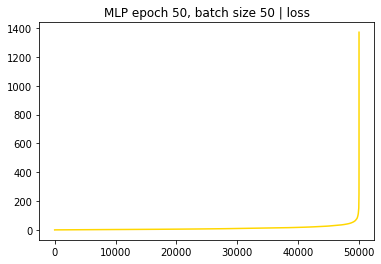

In [8]:
if __name__ == '__main__':
  print("n_iter: 50, learning rate 0.01, batch size 50")
  mlp = MLP()
  # X_train, y_train, X_test, y_test = mnist.load()
  train_x, train_y = mlp.prep_data(train_x, train_y)
  mlp.fit(train_x, train_y)

  # batch size is best 10

In [21]:
eta=0.01
alpha=0.001
n_iter= 50 # epoch test...
batch_size= 100 # batch size

In [22]:
class MLP(object):
    def __init__(self, eta=eta, alpha=alpha, n_iter=n_iter, batch_size=batch_size):
        self.eta = eta
        self.alpha = alpha
        self.n_iter = n_iter
        self.batch_size = batch_size

    def one_hot_enc(self, y, num_labels=10):
        one_hot = np.zeros((num_labels, y.shape[0]), dtype=np.float32)
    
        for i, val in enumerate(y):
            one_hot[val,i] = 1.0
    
        return one_hot

    def init_weights(self, n_input, n_hidden_1, n_hidden_2, n_output, batch_size):
        w1 = np.random.randn(n_hidden_1, n_input+1)
        w2 = np.random.randn(n_hidden_2, n_hidden_1+1)
        w3 = np.random.randn(n_output, n_hidden_2+1)
        
        return w1, w2, w3


    def add_bias_unit(self, layer, orientation):
        if orientation == 'row':
            updated_layer = np.ones((layer.shape[0]+1, layer.shape[1]))
            updated_layer[1:, :] = layer
        elif orientation == 'col':
            updated_layer = np.ones((layer.shape[0], layer.shape[1] + 1))
            updated_layer[:, 1:] = layer
    
        return updated_layer


    def compute_forward_pass(self, input):
        a1 = self.add_bias_unit(input, orientation='col')
    
        z2 = np.matmul(self.w1, a1.transpose(1, 0))
        a2 = 1/(1 + np.exp(-z2))
        a2 = self.add_bias_unit(a2, orientation='row')
    
        z3 = np.matmul(self.w2, a2)
        a3 = 1/(1 + np.exp(-z3))
        a3 = self.add_bias_unit(a3, orientation='row')
    
        z4 = np.matmul(self.w3, a3)
        a4 = 1/(1 + np.exp(-z4))
    
        return a1, z2, a2, z3, a3, z4, a4


    def predict(self, a4):
        prediction = np.argmax(a4, axis=0)
        return prediction

    def compute_loss(self, prediction, label):
        term_1 = -1*label * np.log(prediction)
        term_2 = (1-label)*(np.log(1-prediction))
    
        loss = np.sum(term_1 - term_2)
        return loss


    def compute_backward_pass(self, outputs, label):
        a1, z2, a2, z3, a3, z4, a4 = outputs
    
        delta_4 = a4 - label
        sig_z3 = np.array(1/(1 + np.exp(-z3)))
        delta_3 = np.matmul(self.w3[:,1:].transpose(),delta_4)*sig_z3*(1-sig_z3)
               
        sig_z2 = np.array(1/(1 + np.exp(-z2)))
        delta_2 = np.matmul(self.w2[:,1:], delta_3)*(sig_z2)*(1-(sig_z2))
    
        grad_w1 = np.matmul(delta_2, a1)
        grad_w2 = np.matmul(delta_3, a2.transpose())
        grad_w3 = np.matmul(delta_4, a3.transpose())
    
        return grad_w1, grad_w2, grad_w3
            
    def norm(self, X, x_min, x_max):
        nom = (X-X.min(axis=0))*(x_max-x_min)
        denom = X.max(axis=0) - X.min(axis=0)
        denom[denom==0] = 1
        return x_min + nom/denom 


    def prep_data(self, X, y):
        X_ = []
        y_ = []
        
        itr = int(len(y)/self.batch_size)+1
        for j in range(1,itr):
            rng = j*self.batch_size
            X_.append(X[rng-self.batch_size:rng, :])
            y_.append(y[rng-self.batch_size:rng])
        
        X, y = np.array(X_), np.array(y_)
        X = self.norm(X, 0, 1)
        
        return X, y


    def fit(self, X, y):
        n_input = len(X[0,0,:]) #returns the flattened image size (28*28 = 784)
    
        n_hidden_1, n_hidden_2, n_output = 100, 100, 10
        self.w1, self.w2, self.w3 = self.init_weights(n_input, n_hidden_1, n_hidden_2,
                                    n_output, self.batch_size)

        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)
        delta_w3_prev = np.zeros(self.w3.shape)
        
        train_losses = []
        train_acc = []
    
        train_losses.sort()
        for i in range(self.n_iter):
            for j, (input, label) in enumerate(zip(X, y)):
                one_hot_label = self.one_hot_enc(label, num_labels=10)
                
                a1, z2, a2, z3, a3, z4, a4 = self.compute_forward_pass(input)
                loss = self.compute_loss(a4, one_hot_label)
                grad1, grad2, grad3 = self.compute_backward_pass([a1, z2, a2, z3, a3, z4, a4],
                                                one_hot_label)
    
                delta_w1, delta_w2, delta_w3 = self.eta*grad1, self.eta*grad2, self.eta*grad3
    
                self.w1 -= delta_w1 + delta_w1_prev*self.alpha
                self.w2 -= delta_w2 + delta_w2_prev*self.alpha
                self.w3 -= delta_w3 + delta_w3_prev*self.alpha
    
                delta_w1_prev, delta_w2_prev, delta_w3_prev = delta_w1, delta_w2, delta_w3
    
                train_losses.append(loss)
                predictions = self.predict(a4)
    
                wrong = np.where(predictions != label,
                                np.matrix([1.]), np.matrix([0.]))
    
                accuracy = 1 - np.sum(wrong)/self.batch_size
    
                train_acc.append(accuracy)
    
            print('epoch ', i, 'training accuracy %.2f' %
                    np.mean(np.matrix(train_acc)).item())


        train_losses.sort()        
        plt.plot(train_losses, "deeppink")
        plt.title("MLP epoch 50, batch size 100 | loss")
        plt.show()

n_iter: 50, learning rate 0.01, batch size 100
epoch  0 training accuracy 0.72
epoch  1 training accuracy 0.80
epoch  2 training accuracy 0.83
epoch  3 training accuracy 0.85
epoch  4 training accuracy 0.86
epoch  5 training accuracy 0.87
epoch  6 training accuracy 0.88
epoch  7 training accuracy 0.89
epoch  8 training accuracy 0.90
epoch  9 training accuracy 0.90
epoch  10 training accuracy 0.91
epoch  11 training accuracy 0.91
epoch  12 training accuracy 0.91
epoch  13 training accuracy 0.92
epoch  14 training accuracy 0.92
epoch  15 training accuracy 0.92
epoch  16 training accuracy 0.92
epoch  17 training accuracy 0.93
epoch  18 training accuracy 0.93
epoch  19 training accuracy 0.93
epoch  20 training accuracy 0.93
epoch  21 training accuracy 0.94
epoch  22 training accuracy 0.94
epoch  23 training accuracy 0.94
epoch  24 training accuracy 0.94
epoch  25 training accuracy 0.94
epoch  26 training accuracy 0.94
epoch  27 training accuracy 0.94
epoch  28 training accuracy 0.95
epoch 

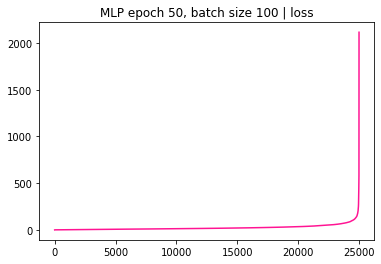

In [23]:
if __name__ == '__main__':
  print("n_iter: 50, learning rate 0.01, batch size 100")
  mlp = MLP()
  # X_train, y_train, X_test, y_test = mnist.load()
  train_x, train_y = mlp.prep_data(train_x, train_y)
  mlp.fit(train_x, train_y)

  # batch size is best 50

In [40]:
eta=0.01
alpha=0.001
n_iter= 50 # epoch test...
batch_size= 10 # bach size

In [41]:
if __name__ == '__main__':
    train_set, val_set, test_set = load_data('mnist.pkl.gz')

    train_x, train_y = train_set
    val_x, val_y = val_set
    test_x, test_y = test_set
    
    print(train_x.shape)
    print(train_y.shape)

... loading data
(50000, 784)
(50000,)


In [42]:
class MLP(object):
    def __init__(self, eta=eta, alpha=alpha, n_iter=n_iter, batch_size=batch_size):
        self.eta = eta
        self.alpha = alpha
        self.n_iter = n_iter
        self.batch_size = batch_size

    def one_hot_enc(self, y, num_labels=10):
        one_hot = np.zeros((num_labels, y.shape[0]), dtype=np.float32)
    
        for i, val in enumerate(y):
            one_hot[val,i] = 1.0
    
        return one_hot

    def init_weights(self, n_input, n_hidden_1, n_hidden_2, n_output, batch_size):
        w1 = np.random.randn(n_hidden_1, n_input+1)
        w2 = np.random.randn(n_hidden_2, n_hidden_1+1)
        w3 = np.random.randn(n_output, n_hidden_2+1)
        
        return w1, w2, w3


    def add_bias_unit(self, layer, orientation):
        if orientation == 'row':
            updated_layer = np.ones((layer.shape[0]+1, layer.shape[1]))
            updated_layer[1:, :] = layer
        elif orientation == 'col':
            updated_layer = np.ones((layer.shape[0], layer.shape[1] + 1))
            updated_layer[:, 1:] = layer
    
        return updated_layer


    def compute_forward_pass(self, input):
        a1 = self.add_bias_unit(input, orientation='col')
    
        z2 = np.matmul(self.w1, a1.transpose(1, 0))
        a2 = 1/(1 + np.exp(-z2))
        a2 = self.add_bias_unit(a2, orientation='row')
    
        z3 = np.matmul(self.w2, a2)
        a3 = 1/(1 + np.exp(-z3))
        a3 = self.add_bias_unit(a3, orientation='row')
    
        z4 = np.matmul(self.w3, a3)
        a4 = 1/(1 + np.exp(-z4))
    
        return a1, z2, a2, z3, a3, z4, a4


    def predict(self, a4):
        prediction = np.argmax(a4, axis=0)
        return prediction

    def compute_loss(self, prediction, label):
        term_1 = -1*label * np.log(prediction)
        term_2 = (1-label)*(np.log(1-prediction))
    
        loss = np.sum(term_1 - term_2)
        return loss


    def compute_backward_pass(self, outputs, label):
        a1, z2, a2, z3, a3, z4, a4 = outputs
    
        delta_4 = a4 - label
        sig_z3 = np.array(1/(1 + np.exp(-z3)))
        delta_3 = np.matmul(self.w3[:,1:].transpose(),delta_4)*sig_z3*(1-sig_z3)
               
        sig_z2 = np.array(1/(1 + np.exp(-z2)))
        delta_2 = np.matmul(self.w2[:,1:], delta_3)*(sig_z2)*(1-(sig_z2))
    
        grad_w1 = np.matmul(delta_2, a1)
        grad_w2 = np.matmul(delta_3, a2.transpose())
        grad_w3 = np.matmul(delta_4, a3.transpose())
    
        return grad_w1, grad_w2, grad_w3
            
    def norm(self, X, x_min, x_max):
        nom = (X-X.min(axis=0))*(x_max-x_min)
        denom = X.max(axis=0) - X.min(axis=0)
        denom[denom==0] = 1
        return x_min + nom/denom 


    def prep_data(self, X, y):
        X_ = []
        y_ = []
        
        itr = int(len(y)/self.batch_size)+1
        for j in range(1,itr):
            rng = j*self.batch_size
            X_.append(X[rng-self.batch_size:rng, :])
            y_.append(y[rng-self.batch_size:rng])
        
        X, y = np.array(X_), np.array(y_)
        X = self.norm(X, 0, 1)
        
        return X, y


    def fit(self, X, y):
        n_input = len(X[0,0,:]) #returns the flattened image size (28*28 = 784)
    
        n_hidden_1, n_hidden_2, n_output = 100, 100, 10
        self.w1, self.w2, self.w3 = self.init_weights(n_input, n_hidden_1, n_hidden_2,
                                    n_output, self.batch_size)

        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)
        delta_w3_prev = np.zeros(self.w3.shape)
        
        train_losses = []
        train_acc = []
    
        train_losses.sort()
        for i in range(self.n_iter):
            for j, (input, label) in enumerate(zip(X, y)):
                one_hot_label = self.one_hot_enc(label, num_labels=10)
                
                a1, z2, a2, z3, a3, z4, a4 = self.compute_forward_pass(input)
                loss = self.compute_loss(a4, one_hot_label)
                grad1, grad2, grad3 = self.compute_backward_pass([a1, z2, a2, z3, a3, z4, a4],
                                                one_hot_label)
    
                delta_w1, delta_w2, delta_w3 = self.eta*grad1, self.eta*grad2, self.eta*grad3
    
                self.w1 -= delta_w1 + delta_w1_prev*self.alpha
                self.w2 -= delta_w2 + delta_w2_prev*self.alpha
                self.w3 -= delta_w3 + delta_w3_prev*self.alpha
    
                delta_w1_prev, delta_w2_prev, delta_w3_prev = delta_w1, delta_w2, delta_w3
    
                #train_losses.append(loss)
                predictions = self.predict(a4)
    
                wrong = np.where(predictions != label,
                                np.matrix([1.]), np.matrix([0.]))
    
                accuracy = 1 - np.sum(wrong)/self.batch_size
    
                train_acc.append(accuracy)
                train_losses.append(loss/len(X))
            print('epoch ', i, 'training accuracy %.2f' %
                    np.mean(np.matrix(train_acc)).item())


        train_losses.sort()        
        plt.plot(train_losses, "greenyellow")
        plt.title("MLP epoch 50, batch size 10 | loss")
        plt.show()

n_iter: 50
epoch  0 training accuracy 0.75
epoch  1 training accuracy 0.81
epoch  2 training accuracy 0.84
epoch  3 training accuracy 0.86
epoch  4 training accuracy 0.87
epoch  5 training accuracy 0.88
epoch  6 training accuracy 0.89
epoch  7 training accuracy 0.90
epoch  8 training accuracy 0.90
epoch  9 training accuracy 0.91
epoch  10 training accuracy 0.91
epoch  11 training accuracy 0.92
epoch  12 training accuracy 0.92
epoch  13 training accuracy 0.92
epoch  14 training accuracy 0.92
epoch  15 training accuracy 0.93
epoch  16 training accuracy 0.93
epoch  17 training accuracy 0.93
epoch  18 training accuracy 0.93
epoch  19 training accuracy 0.94
epoch  20 training accuracy 0.94
epoch  21 training accuracy 0.94
epoch  22 training accuracy 0.94
epoch  23 training accuracy 0.94
epoch  24 training accuracy 0.94
epoch  25 training accuracy 0.95
epoch  26 training accuracy 0.95
epoch  27 training accuracy 0.95
epoch  28 training accuracy 0.95
epoch  29 training accuracy 0.95
epoch  30

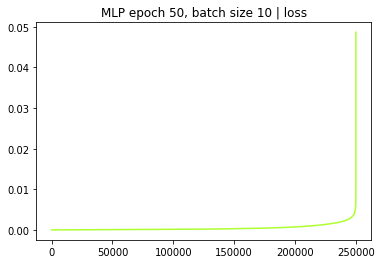

In [43]:
if __name__ == '__main__':
  print("n_iter: 50")
  mlp = MLP()
  # X_train, y_train, X_test, y_test = mnist.load()
  train_x, train_y = mlp.prep_data(train_x, train_y)
  mlp.fit(train_x, train_y)

In [44]:
eta=0.01
alpha=0.001
n_iter= 100 # epoch 100
batch_size= 10 # bach size

In [45]:
if __name__ == '__main__':
    train_set, val_set, test_set = load_data('mnist.pkl.gz')

    train_x, train_y = train_set
    val_x, val_y = val_set
    test_x, test_y = test_set
    
    print(train_x.shape)
    print(train_y.shape)

... loading data
(50000, 784)
(50000,)


In [46]:
class MLP(object):
    def __init__(self, eta=eta, alpha=alpha, n_iter=n_iter, batch_size=batch_size):
        self.eta = eta
        self.alpha = alpha
        self.n_iter = n_iter
        self.batch_size = batch_size

    def one_hot_enc(self, y, num_labels=10):
        one_hot = np.zeros((num_labels, y.shape[0]), dtype=np.float32)
    
        for i, val in enumerate(y):
            one_hot[val,i] = 1.0
    
        return one_hot

    def init_weights(self, n_input, n_hidden_1, n_hidden_2, n_output, batch_size):
        w1 = np.random.randn(n_hidden_1, n_input+1)
        w2 = np.random.randn(n_hidden_2, n_hidden_1+1)
        w3 = np.random.randn(n_output, n_hidden_2+1)
        
        return w1, w2, w3


    def add_bias_unit(self, layer, orientation):
        if orientation == 'row':
            updated_layer = np.ones((layer.shape[0]+1, layer.shape[1]))
            updated_layer[1:, :] = layer
        elif orientation == 'col':
            updated_layer = np.ones((layer.shape[0], layer.shape[1] + 1))
            updated_layer[:, 1:] = layer
    
        return updated_layer


    def compute_forward_pass(self, input):
        a1 = self.add_bias_unit(input, orientation='col')
    
        z2 = np.matmul(self.w1, a1.transpose(1, 0))
        a2 = 1/(1 + np.exp(-z2))
        a2 = self.add_bias_unit(a2, orientation='row')
    
        z3 = np.matmul(self.w2, a2)
        a3 = 1/(1 + np.exp(-z3))
        a3 = self.add_bias_unit(a3, orientation='row')
    
        z4 = np.matmul(self.w3, a3)
        a4 = 1/(1 + np.exp(-z4))
    
        return a1, z2, a2, z3, a3, z4, a4


    def predict(self, a4):
        prediction = np.argmax(a4, axis=0)
        return prediction

    def compute_loss(self, prediction, label):
        term_1 = -1*label * np.log(prediction)
        term_2 = (1-label)*(np.log(1-prediction))
    
        loss = np.sum(term_1 - term_2)
        return loss


    def compute_backward_pass(self, outputs, label):
        a1, z2, a2, z3, a3, z4, a4 = outputs
    
        delta_4 = a4 - label
        sig_z3 = np.array(1/(1 + np.exp(-z3)))
        delta_3 = np.matmul(self.w3[:,1:].transpose(),delta_4)*sig_z3*(1-sig_z3)
               
        sig_z2 = np.array(1/(1 + np.exp(-z2)))
        delta_2 = np.matmul(self.w2[:,1:], delta_3)*(sig_z2)*(1-(sig_z2))
    
        grad_w1 = np.matmul(delta_2, a1)
        grad_w2 = np.matmul(delta_3, a2.transpose())
        grad_w3 = np.matmul(delta_4, a3.transpose())
    
        return grad_w1, grad_w2, grad_w3
            
    def norm(self, X, x_min, x_max):
        nom = (X-X.min(axis=0))*(x_max-x_min)
        denom = X.max(axis=0) - X.min(axis=0)
        denom[denom==0] = 1
        return x_min + nom/denom 


    def prep_data(self, X, y):
        X_ = []
        y_ = []
        
        itr = int(len(y)/self.batch_size)+1
        for j in range(1,itr):
            rng = j*self.batch_size
            X_.append(X[rng-self.batch_size:rng, :])
            y_.append(y[rng-self.batch_size:rng])
        
        X, y = np.array(X_), np.array(y_)
        X = self.norm(X, 0, 1)
        
        return X, y


    def fit(self, X, y):
        n_input = len(X[0,0,:]) #returns the flattened image size (28*28 = 784)
    
        n_hidden_1, n_hidden_2, n_output = 100, 100, 10
        self.w1, self.w2, self.w3 = self.init_weights(n_input, n_hidden_1, n_hidden_2,
                                    n_output, self.batch_size)

        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)
        delta_w3_prev = np.zeros(self.w3.shape)
        
        train_losses = []
        train_acc = []
    
        train_losses.sort()
        for i in range(self.n_iter):
            for j, (input, label) in enumerate(zip(X, y)):
                one_hot_label = self.one_hot_enc(label, num_labels=10)
                
                a1, z2, a2, z3, a3, z4, a4 = self.compute_forward_pass(input)
                loss = self.compute_loss(a4, one_hot_label)
                grad1, grad2, grad3 = self.compute_backward_pass([a1, z2, a2, z3, a3, z4, a4],
                                                one_hot_label)
    
                delta_w1, delta_w2, delta_w3 = self.eta*grad1, self.eta*grad2, self.eta*grad3
    
                self.w1 -= delta_w1 + delta_w1_prev*self.alpha
                self.w2 -= delta_w2 + delta_w2_prev*self.alpha
                self.w3 -= delta_w3 + delta_w3_prev*self.alpha
    
                delta_w1_prev, delta_w2_prev, delta_w3_prev = delta_w1, delta_w2, delta_w3
    
                #train_losses.append(loss)
                predictions = self.predict(a4)
    
                wrong = np.where(predictions != label,
                                np.matrix([1.]), np.matrix([0.]))
    
                accuracy = 1 - np.sum(wrong)/self.batch_size
    
                train_acc.append(accuracy)
                train_losses.append(loss/len(X))
            print('epoch ', i, 'training accuracy %.2f' %
                    np.mean(np.matrix(train_acc)).item())


        train_losses.sort()        
        plt.plot(train_losses, "darkviolet")
        plt.title("MLP epoch 100, batch size 10 | loss")
        plt.show()

n_iter: 100, batch size 10, learning rate 0.01
epoch  0 training accuracy 0.74
epoch  1 training accuracy 0.80
epoch  2 training accuracy 0.83
epoch  3 training accuracy 0.85
epoch  4 training accuracy 0.87
epoch  5 training accuracy 0.88
epoch  6 training accuracy 0.89
epoch  7 training accuracy 0.89
epoch  8 training accuracy 0.90
epoch  9 training accuracy 0.91
epoch  10 training accuracy 0.91
epoch  11 training accuracy 0.91
epoch  12 training accuracy 0.92
epoch  13 training accuracy 0.92
epoch  14 training accuracy 0.92
epoch  15 training accuracy 0.93
epoch  16 training accuracy 0.93
epoch  17 training accuracy 0.93
epoch  18 training accuracy 0.93
epoch  19 training accuracy 0.93
epoch  20 training accuracy 0.94
epoch  21 training accuracy 0.94
epoch  22 training accuracy 0.94
epoch  23 training accuracy 0.94
epoch  24 training accuracy 0.94
epoch  25 training accuracy 0.94
epoch  26 training accuracy 0.95
epoch  27 training accuracy 0.95
epoch  28 training accuracy 0.95
epoch 

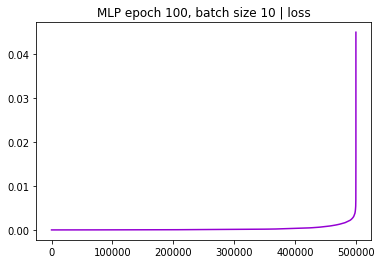

In [47]:
if __name__ == '__main__':
  print("n_iter: 100, batch size 10, learning rate 0.01")
  mlp = MLP()
  # X_train, y_train, X_test, y_test = mnist.load()
  train_x, train_y = mlp.prep_data(train_x, train_y)
  mlp.fit(train_x, train_y)

In [7]:
eta=0.01
alpha=0.001
n_iter= 200 # epoch 200
batch_size= 10 # bach size

In [33]:
if __name__ == '__main__':
    train_set, val_set, test_set = load_data('mnist.pkl.gz')

    train_x, train_y = train_set
    val_x, val_y = val_set
    test_x, test_y = test_set
    
    print(train_x.shape)
    print(train_y.shape)

... loading data
(50000, 784)
(50000,)


In [9]:
class MLP(object):
    def __init__(self, eta=eta, alpha=alpha, n_iter=n_iter, batch_size=batch_size):
        self.eta = eta
        self.alpha = alpha
        self.n_iter = n_iter
        self.batch_size = batch_size

    def one_hot_enc(self, y, num_labels=10):
        one_hot = np.zeros((num_labels, y.shape[0]), dtype=np.float32)
    
        for i, val in enumerate(y):
            one_hot[val,i] = 1.0
    
        return one_hot

    def init_weights(self, n_input, n_hidden_1, n_hidden_2, n_output, batch_size):
        w1 = np.random.randn(n_hidden_1, n_input+1)
        w2 = np.random.randn(n_hidden_2, n_hidden_1+1)
        w3 = np.random.randn(n_output, n_hidden_2+1)
        
        return w1, w2, w3


    def add_bias_unit(self, layer, orientation):
        if orientation == 'row':
            updated_layer = np.ones((layer.shape[0]+1, layer.shape[1]))
            updated_layer[1:, :] = layer
        elif orientation == 'col':
            updated_layer = np.ones((layer.shape[0], layer.shape[1] + 1))
            updated_layer[:, 1:] = layer
    
        return updated_layer


    def compute_forward_pass(self, input):
        a1 = self.add_bias_unit(input, orientation='col')
    
        z2 = np.matmul(self.w1, a1.transpose(1, 0))
        a2 = 1/(1 + np.exp(-z2))
        a2 = self.add_bias_unit(a2, orientation='row')
    
        z3 = np.matmul(self.w2, a2)
        a3 = 1/(1 + np.exp(-z3))
        a3 = self.add_bias_unit(a3, orientation='row')
    
        z4 = np.matmul(self.w3, a3)
        a4 = 1/(1 + np.exp(-z4))
    
        return a1, z2, a2, z3, a3, z4, a4


    def predict(self, a4):
        prediction = np.argmax(a4, axis=0)
        return prediction

    def compute_loss(self, prediction, label):
        term_1 = -1*label * np.log(prediction)
        term_2 = (1-label)*(np.log(1-prediction))
    
        loss = np.sum(term_1 - term_2)
        return loss


    def compute_backward_pass(self, outputs, label):
        a1, z2, a2, z3, a3, z4, a4 = outputs
    
        delta_4 = a4 - label
        sig_z3 = np.array(1/(1 + np.exp(-z3)))
        delta_3 = np.matmul(self.w3[:,1:].transpose(),delta_4)*sig_z3*(1-sig_z3)
               
        sig_z2 = np.array(1/(1 + np.exp(-z2)))
        delta_2 = np.matmul(self.w2[:,1:], delta_3)*(sig_z2)*(1-(sig_z2))
    
        grad_w1 = np.matmul(delta_2, a1)
        grad_w2 = np.matmul(delta_3, a2.transpose())
        grad_w3 = np.matmul(delta_4, a3.transpose())
    
        return grad_w1, grad_w2, grad_w3
            
    def norm(self, X, x_min, x_max):
        nom = (X-X.min(axis=0))*(x_max-x_min)
        denom = X.max(axis=0) - X.min(axis=0)
        denom[denom==0] = 1
        return x_min + nom/denom 


    def prep_data(self, X, y):
        X_ = []
        y_ = []
        
        itr = int(len(y)/self.batch_size)+1
        for j in range(1,itr):
            rng = j*self.batch_size
            X_.append(X[rng-self.batch_size:rng, :])
            y_.append(y[rng-self.batch_size:rng])
        
        X, y = np.array(X_), np.array(y_)
        X = self.norm(X, 0, 1)
        
        return X, y


    def fit(self, X, y):
        n_input = len(X[0,0,:]) #returns the flattened image size (28*28 = 784)
    
        n_hidden_1, n_hidden_2, n_output = 100, 100, 10
        self.w1, self.w2, self.w3 = self.init_weights(n_input, n_hidden_1, n_hidden_2,
                                    n_output, self.batch_size)

        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)
        delta_w3_prev = np.zeros(self.w3.shape)
        
        train_losses = []
        train_acc = []
    
        train_losses.sort()
        for i in range(self.n_iter):
            for j, (input, label) in enumerate(zip(X, y)):
                one_hot_label = self.one_hot_enc(label, num_labels=10)
                
                a1, z2, a2, z3, a3, z4, a4 = self.compute_forward_pass(input)
                loss = self.compute_loss(a4, one_hot_label)
                grad1, grad2, grad3 = self.compute_backward_pass([a1, z2, a2, z3, a3, z4, a4],
                                                one_hot_label)
    
                delta_w1, delta_w2, delta_w3 = self.eta*grad1, self.eta*grad2, self.eta*grad3
    
                self.w1 -= delta_w1 + delta_w1_prev*self.alpha
                self.w2 -= delta_w2 + delta_w2_prev*self.alpha
                self.w3 -= delta_w3 + delta_w3_prev*self.alpha
    
                delta_w1_prev, delta_w2_prev, delta_w3_prev = delta_w1, delta_w2, delta_w3
    
                #train_losses.append(loss)
                predictions = self.predict(a4)
    
                wrong = np.where(predictions != label,
                                np.matrix([1.]), np.matrix([0.]))
    
                accuracy = 1 - np.sum(wrong)/self.batch_size
    
                train_acc.append(accuracy)
                train_losses.append(loss/len(X))
            print('epoch ', i, 'training accuracy %.2f' %
                    np.mean(np.matrix(train_acc)).item())


        train_losses.sort()        
        plt.plot(train_losses, "dodgerblue")
        plt.title("MLP epoch 200, batch size 10 | loss")
        plt.show()

n_iter: 200, batch size 10, learning rate 0.01
epoch  0 training accuracy 0.75
epoch  1 training accuracy 0.81
epoch  2 training accuracy 0.84
epoch  3 training accuracy 0.86
epoch  4 training accuracy 0.87
epoch  5 training accuracy 0.88
epoch  6 training accuracy 0.89
epoch  7 training accuracy 0.90
epoch  8 training accuracy 0.90
epoch  9 training accuracy 0.91
epoch  10 training accuracy 0.91
epoch  11 training accuracy 0.91
epoch  12 training accuracy 0.92
epoch  13 training accuracy 0.92
epoch  14 training accuracy 0.92
epoch  15 training accuracy 0.93
epoch  16 training accuracy 0.93
epoch  17 training accuracy 0.93
epoch  18 training accuracy 0.93
epoch  19 training accuracy 0.93
epoch  20 training accuracy 0.94
epoch  21 training accuracy 0.94
epoch  22 training accuracy 0.94
epoch  23 training accuracy 0.94
epoch  24 training accuracy 0.94
epoch  25 training accuracy 0.94
epoch  26 training accuracy 0.95
epoch  27 training accuracy 0.95
epoch  28 training accuracy 0.95
epoch 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in multiply


epoch  197 training accuracy 0.99
epoch  198 training accuracy 0.99
epoch  199 training accuracy 0.99


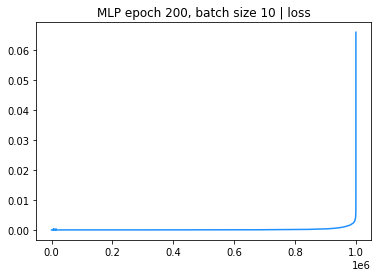

In [10]:
if __name__ == '__main__':
  print("n_iter: 200, batch size 10, learning rate 0.01")
  mlp = MLP()
  # X_train, y_train, X_test, y_test = mnist.load()
  train_x, train_y = mlp.prep_data(train_x, train_y)
  mlp.fit(train_x, train_y)

In [5]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from matplotlib import pyplot as plt
from matplotlib import cm

import pandas as pd

%matplotlib inline

In [6]:
test_x.shape

(10000, 784)

In [8]:
train_X = torch.from_numpy(train_x).float().to(device)
train_Y = torch.from_numpy(train_y).long().to(device)


test_X = torch.from_numpy(test_x).float().to(device)
test_Y = torch.from_numpy(test_y).long().to(device)

print(train_X.shape)
print(train_Y.shape)

torch.Size([50000, 784])
torch.Size([50000])


In [12]:
train = TensorDataset(train_X, train_Y)
train_loader = DataLoader(train, batch_size=50, shuffle=True)

In [13]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(784, 256)
    self.fc2 = nn.Linear(256, 256)
    self.fc3 = nn.Linear(256, 256)
    self.fc4 = nn.Linear(256, 128)
    self.fc5 = nn.Linear(128, 128)
    self.fc6 = nn.Linear(128, 10)
    
    
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = F.relu(self.fc5(x))
    x = F.dropout(x, training=self.training)
    x = self.fc6(x)
    return F.log_softmax(x)
    
model = Net()
#model.cuda()

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [15]:
losses = []
for epoch in range(1000):
  total_loss = 0 #batch loss
  
  for train_x, train_y in train_loader:
    train_x, train_y = Variable(train_x), Variable(train_y)
    optimizer.zero_grad()
    output = model(train_x)

    loss = criterion(output, train_y)
    loss.backward()
    # loss
    optimizer.step()
    total_loss += loss.data.item()
    losses.append(total_loss)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [28]:
if (epoch +1) % 10 == 0:
  print(epoch+1, total_loss)

1000 0.13594104881920277


In [29]:
test_x, test_y = Variable(test_X), Variable(test_Y)

In [30]:
result = torch.max(model(test_x).data, 1)[1]
accuracy = sum(test_y.cpu().data.numpy() == result.cpu().numpy()) / len(test_y.cpu().data.numpy())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [31]:
print("===Pytorch Multi-Layer Perceptron accuracy===")
print(accuracy)

===Pytorch Multi-Layer Perceptron accuracy===
0.9731


In [20]:
losses.sort()

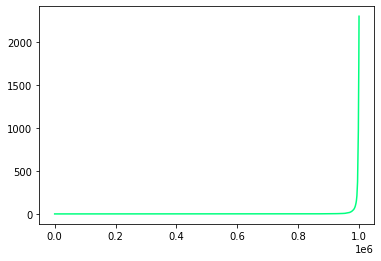

In [27]:
#plot
import matplotlib.pyplot as plt

plt.plot(losses, color = "springgreen")

plt.show()

In [18]:
# pytorch torchvision
import torch
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
import matplotlib.pyplot as plt

In [19]:
num_workers = 0
batch_size = 10 # batch size 10
valid_size = 0.2
n_epochs = 50 # epoch 100

In [20]:

transform = transforms.ToTensor()
# choose the training and testing datasets
train_data = datasets.MNIST(root = 'root', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = 'root', train = False, download = True, transform = transform)
# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_index, valid_index = indices[split:], indices[:split]
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, 
                                           sampler = train_sampler, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                          sampler = valid_sampler, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                         num_workers = num_workers)

In [21]:
import torch.nn as nn
import torch.nn.functional as F
# define NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        # number of hidden nodes in each layer (512)
        hidden_1 = 512
        hidden_2 = 512
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(28*28, 512)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(512,512)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(512,10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.droput = nn.Dropout(0.2)
        
    def forward(self,x):
        # flatten image input
        x = x.view(-1,28*28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.droput(x)
         # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.droput(x)
        # add output layer
        x = self.fc3(x)
        return x
# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (droput): Dropout(p=0.2, inplace=False)
)


In [22]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()
# specify optimizer (stochastic gradient descent) and learning rate = 0.01 ##
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01) 

In [14]:
# This is torchvision data, but compare with from scratch / n_eopchs 50, batch size 10
losses = []
valid_loss_min = np.Inf  # set initial "min" to infinity
for epoch in range(n_epochs):

    train_loss = 0
    valid_loss = 0
    model.train()
    for data, label in train_loader:
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, label)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()*data.size(0)
      losses.append(train_loss/len(train_loader.sampler))

In [15]:
   # validate
   model.eval()  # prep model for evaluation
   for data,label in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,label)
        # update running validation loss 
        valid_loss = loss.item() * data.size(0)

In [16]:
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)

In [17]:
losses.sort() ## bitch size 10, epoch 50

Text(0.5, 1.0, 'Pytorch torchvision dataset | Batch size 10, epoch 50 Loss')

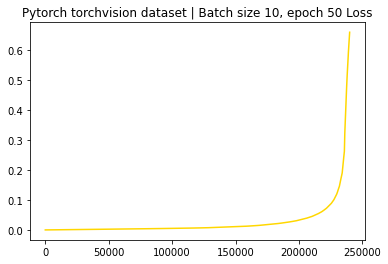

In [18]:
plt.plot(losses, color = "gold")
plt.title("Pytorch torchvision dataset | Batch size 10, epoch 50 Loss")

In [19]:
    print("Batch size 10")
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))

Batch size 10
Epoch: 50 	Training Loss: 0.004914 	Validation Loss: 0.000000


In [20]:
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Validation loss decreased (inf --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...


In [21]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [22]:
test_loss = 0.0 # init
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval()

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (droput): Dropout(p=0.2, inplace=False)
)

In [23]:
test_losses = []
for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))

    test_losses.append(test_loss/len(test_loader.sampler))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
test_losses.sort()
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.064516

Test Accuracy of     0: 98% (969/980)
Test Accuracy of     1: 99% (1127/1135)
Test Accuracy of     2: 97% (1008/1032)
Test Accuracy of     3: 98% (990/1010)
Test Accuracy of     4: 98% (968/982)
Test Accuracy of     5: 98% (878/892)
Test Accuracy of     6: 98% (944/958)
Test Accuracy of     7: 98% (1009/1028)
Test Accuracy of     8: 97% (948/974)
Test Accuracy of     9: 97% (988/1009)

Test Accuracy (Overall): 98% (9829/10000)
Test Loss: 0.064522

Test Accuracy of     0: 98% (1938/1960)
Test Accuracy of     1: 99% (2254/2270)
Test Accuracy of     2: 97% (2016/2064)
Test Accuracy of     3: 98% (1980/2020)
Test Accuracy of     4: 98% (1936/1964)
Test Accuracy of     5: 98% (1756/1784)
Test Accuracy of     6: 98% (1888/1916)
Test Accuracy of     7: 98% (2018/2056)
Test Accuracy of     8: 97% (1896/1948)
Test Accuracy of     9: 97% (1976/2018)

Test Accuracy (Overall): 98% (19658/20000)


Text(0.5, 1.0, 'Pytorch torchvision dataset | test loss(batch size10, epoch50)')

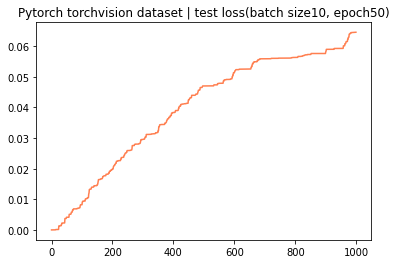

In [24]:
plt.plot(test_losses, color = "coral")
plt.title("Pytorch torchvision dataset | test loss(batch size10, epoch50)") # epoch 50, batch size 10

In [25]:
num_workers = 0
batch_size = 10 # batch size 10
valid_size = 0.2
n_epochs = 100 # epoch 100

In [26]:
# This is torchvision data, but compare with from scratch / n_eopchs 100, batch size 10
losses = []
valid_loss_min = np.Inf  # set initial "min" to infinity
for epoch in range(n_epochs):

    train_loss = 0
    valid_loss = 0
    model.train()
    for data, label in train_loader:
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, label)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()*data.size(0)
      losses.append(train_loss/len(train_loader.sampler))


In [27]:
   # validate, 
   model.eval()  # prep model for evaluation
   for data,label in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,label)
        # update running validation loss 
        valid_loss = loss.item() * data.size(0)

In [28]:
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)

In [29]:
losses.sort() # batch size 10, epoch 100

Text(0.5, 1.0, 'Pytorch torchvision dataset | Batch size 10, epoch 100 Loss')

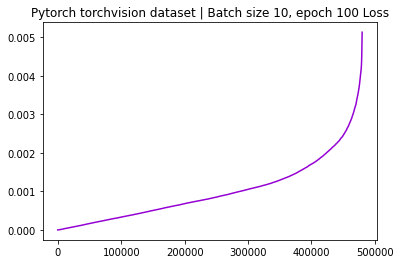

In [30]:
plt.plot(losses, color = "darkviolet")
plt.title("Pytorch torchvision dataset | Batch size 10, epoch 100 Loss")

In [31]:
    print("Batch size 10")
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))

Batch size 10
Epoch: 100 	Training Loss: 0.000921 	Validation Loss: 0.000000


In [32]:
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss    # save model if validation loss has decreased

Validation loss decreased (inf --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...


In [33]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [34]:
test_loss = 0.0 # init
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval()

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (droput): Dropout(p=0.2, inplace=False)
)

In [35]:
test_losses = []
for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))

    test_losses.append(test_loss/len(test_loader.sampler))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
test_losses.sort()
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.075032

Test Accuracy of     0: 99% (971/980)
Test Accuracy of     1: 99% (1127/1135)
Test Accuracy of     2: 98% (1013/1032)
Test Accuracy of     3: 98% (994/1010)
Test Accuracy of     4: 98% (966/982)
Test Accuracy of     5: 97% (874/892)
Test Accuracy of     6: 98% (945/958)
Test Accuracy of     7: 98% (1009/1028)
Test Accuracy of     8: 97% (947/974)
Test Accuracy of     9: 98% (991/1009)

Test Accuracy (Overall): 98% (9837/10000)
Test Loss: 0.075039

Test Accuracy of     0: 99% (1942/1960)
Test Accuracy of     1: 99% (2254/2270)
Test Accuracy of     2: 98% (2026/2064)
Test Accuracy of     3: 98% (1988/2020)
Test Accuracy of     4: 98% (1932/1964)
Test Accuracy of     5: 97% (1748/1784)
Test Accuracy of     6: 98% (1890/1916)
Test Accuracy of     7: 98% (2018/2056)
Test Accuracy of     8: 97% (1894/1948)
Test Accuracy of     9: 98% (1982/2018)

Test Accuracy (Overall): 98% (19674/20000)


Text(0.5, 1.0, 'Pytorch torchvision dataset | test loss(batch size10, epoch100)')

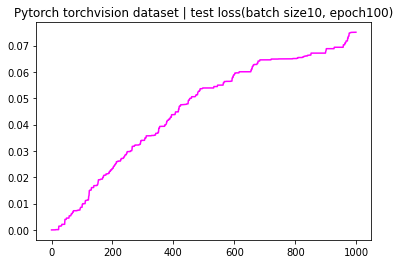

In [37]:
plt.plot(test_losses, color = "magenta")
plt.title("Pytorch torchvision dataset | test loss(batch size10, epoch100)") # epoch 50, batch size

In [23]:
# batch size 10, epoch 200
num_workers = 0
batch_size = 10 # batch size 10
valid_size = 0.2
n_epochs = 200 # epoch 200

In [24]:
# This is torchvision data, but compare with from scratch / n_eopchs 200, batch size 10
losses = []
valid_loss_min = np.Inf  # set initial "min" to infinity
for epoch in range(n_epochs):

    train_loss = 0
    valid_loss = 0
    model.train()
    for data, label in train_loader:
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, label)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()*data.size(0)
      losses.append(train_loss/len(train_loader.sampler))

In [25]:
   # validate, 
   model.eval()  # prep model for evaluation
   for data,label in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,label)
        # update running validation loss 
        valid_loss = loss.item() * data.size(0)

In [26]:
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)

In [27]:
losses.sort() # batch size 10, epoch 200

Text(0.5, 1.0, 'Pytorch torchvision dataset | Batch size 10, epoch 200 Loss')

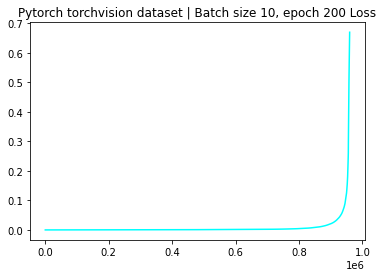

In [28]:
plt.plot(losses, color = "aqua")
plt.title("Pytorch torchvision dataset | Batch size 10, epoch 200 Loss")

In [29]:
    print("Batch size 10")
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))

Batch size 10
Epoch: 200 	Training Loss: 0.000666 	Validation Loss: 0.000318


In [30]:
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss    # save model if validation loss has decreased

Validation loss decreased (inf --> 0.000318).  Saving model ...


In [31]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [32]:
test_loss = 0.0 # init
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval()

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (droput): Dropout(p=0.2, inplace=False)
)

In [33]:
test_losses = []
for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))

    test_losses.append(test_loss/len(test_loader.sampler))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
test_losses.sort()
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.072217

Test Accuracy of     0: 99% (973/980)
Test Accuracy of     1: 99% (1128/1135)
Test Accuracy of     2: 98% (1014/1032)
Test Accuracy of     3: 98% (998/1010)
Test Accuracy of     4: 98% (964/982)
Test Accuracy of     5: 98% (876/892)
Test Accuracy of     6: 98% (946/958)
Test Accuracy of     7: 97% (1006/1028)
Test Accuracy of     8: 97% (954/974)
Test Accuracy of     9: 98% (992/1009)

Test Accuracy (Overall): 98% (9851/10000)


Text(0.5, 1.0, 'Pytorch torchvision dataset | test loss(batch size10, epoch200)')

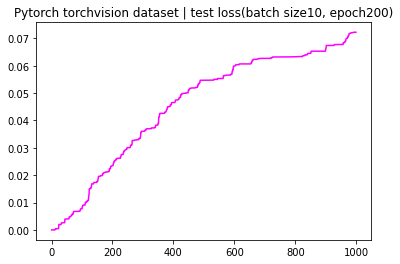

In [34]:
plt.plot(test_losses, color = "magenta")
plt.title("Pytorch torchvision dataset | test loss(batch size10, epoch200)") # epoch 50, bachsize